<a href="https://colab.research.google.com/github/JamadadeHarshita/NlpSpeechToText/blob/main/Mini_Project_Harshita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Speech Recognition and NLP Analysis of Academic Lectures**


This project transcribes spoken lectures using speech-to-text models and applies NLP techniques for analysis, making academic content easier to understand.

**USE CASE** : This project is for students, educators, and researchers who need to quickly review and understand academic lectures. By converting speech into text and summarizing key points, it makes complex content easier to digest.

## Setup and Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install yt-dlp
!apt-get install ffmpeg
!pip install pydub
!pip install ffmpeg
!pip install SpeechRecognition
!pip install git+https://github.com/openai/whisper.git
!apt-get install ffmpeg
!pip install gensim
!pip install keybert
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 25.9 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=473d6423a4ab24132012e7dfb78d46b1f5ba0e90202b1e867ff7469b410a2eaa
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 26.8 MB/s eta 0:00:00
  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-gzwqkd4v
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-gzwqkd4v
  Resolved http

In [ ]:
# Audio Download and File Handling
import yt_dlp
import os
import soundfile as sf

# Speech Recognition and Whisper Model
import speech_recognition as sr
import whisper

# NLP and Text Processing
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk import ngrams
nltk.download("punkt")
import spacy
from collections import Counter

# Transformers for NLP Models
from transformers import (
    pipeline,
     BartTokenizer,
    BartForConditionalGeneration
)

from scipy.spatial.distance import cosine

# Visualization Libraries
import matplotlib.pyplot as plt
import networkx as nx

import pandas as pd
import gensim
from gensim import corpora
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from keybert import KeyBERT

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## **Data Collection**
Audio Source: The audio data is collected using the **yt-dlp** package



*   With the yt_dl package we can download audio and video files from a URL and convert to a .wav file
*   Youtube_dl supports an extensive collection (~ 240) of websites




In [ ]:
def download_audio_from_youtube(url, output_file='audio_yt'):
    ydl_opts = {
        'format': 'bestaudio/best',
        'extractaudio': True,  # Only download audio
        'audioformat': 'wav',  # Convert to wav format
        'outtmpl': output_file,  # Output file name
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'wav',
            'preferredquality': '192',
        }],
    }

    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])
    print(f"Downloaded and saved as {output_file}")

# Get user input for the URL
url = input("Please enter a URL from which you want to download a video: ")
download_audio_from_youtube(url)


Please enter a URL from which you want to download a video: https://youtu.be/9vM4p9NN0Ts?si=QT3I2az_6l1b1UkK
[youtube] Extracting URL: https://youtu.be/9vM4p9NN0Ts?si=QT3I2az_6l1b1UkK
[youtube] 9vM4p9NN0Ts: Downloading webpage
[youtube] 9vM4p9NN0Ts: Downloading ios player API JSON
[youtube] 9vM4p9NN0Ts: Downloading mweb player API JSON
[youtube] 9vM4p9NN0Ts: Downloading m3u8 information
[info] 9vM4p9NN0Ts: Downloading 1 format(s): 251
[download] Destination: audio_yt
[download] 100% of   75.27MiB in 00:00:01 at 41.53MiB/s  
[ExtractAudio] Destination: audio_yt.wav
Deleting original file audio_yt (pass -k to keep)
Downloaded and saved as audio_yt


It prompts the user to input a URL. For this project, I provided https://www.youtube.com/watch?v=9vM4p9NN0Ts, which is a Stanford lecture about Large Language Models (LLMs) . The audio is then converted into a .wav format for further processing.

In [ ]:
file_path = "/content/audio_yt.wav"
f = sf.SoundFile(file_path)

# Calculate the video length in seconds
video_length = int(len(f) / f.samplerate) + (len(f) % f.samplerate > 0)
print(f"Video Length: {video_length} seconds")

Video Length: 6271 seconds


# **Speech Recognition**
**Transcription Method**: For transcribing the audio, I used OpenAI’s **Whisper**, Whisper is trained on a large and diverse dataset, making it effective at transcribing speech across various languages and audio qualities.

In [ ]:
model = whisper.load_model("base")

100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 96.3MiB/s]
/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

I chose the "base" model of Whisper because The "base" model is smaller and faster compared to larger models, making it suitable for this project where quick transcription is needed.

In [ ]:
def transcribe_audio_in_chunks(file_path):
    # Read the audio file
    data, samplerate = sf.read(file_path)
    audio_length = int(len(data) / samplerate)

    # Set the chunk duration (in seconds)
    chunk_duration = 60
    number_of_chunks = int(audio_length / chunk_duration) + (audio_length % chunk_duration > 0)

    print(f"Total audio length: {audio_length} seconds")
    print(f"Number of chunks: {number_of_chunks}")

    complete_transcription = ""

    # Loop through the audio file in chunks
    for i in range(number_of_chunks):
        start = i * chunk_duration
        end = (i + 1) * chunk_duration
        if end > audio_length:
            end = audio_length

        # Extract the chunk
        start_frame = int(start * samplerate)
        end_frame = int(end * samplerate)
        chunk = data[start_frame:end_frame]

        # Save the chunk as a temporary file
        temp_filename = "temp_chunk.wav"
        sf.write(temp_filename, chunk, samplerate)

        # Transcribe the chunk using Whisper
        result = model.transcribe(temp_filename)
        complete_transcription += result["text"] + " "

        print(f"Transcribed chunk from {start} to {end} seconds.")

    return complete_transcription


### Transcribing Audio in Chunks:
 For long audio files, transcribing the entire content at once can be inefficient and may cause memory issues. To handle this,Implementation of a function that breaks the audio into smaller chunks, transcribes each chunk using the Whisper model, and then combines the results into a complete transcription.

In [ ]:
transcription = transcribe_audio_in_chunks(file_path)
print("Complete Transcription: ", transcription)

Total audio length: 6270 seconds
Number of chunks: 105


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 0 to 60 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 60 to 120 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 120 to 180 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 180 to 240 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 240 to 300 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 300 to 360 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 360 to 420 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 420 to 480 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 480 to 540 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 540 to 600 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 600 to 660 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 660 to 720 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 720 to 780 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 780 to 840 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 840 to 900 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 900 to 960 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 960 to 1020 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 1020 to 1080 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 1080 to 1140 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 1140 to 1200 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 1200 to 1260 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 1260 to 1320 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 1320 to 1380 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 1380 to 1440 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 1440 to 1500 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 1500 to 1560 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 1560 to 1620 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 1620 to 1680 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 1680 to 1740 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 1740 to 1800 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 1800 to 1860 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 1860 to 1920 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 1920 to 1980 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 1980 to 2040 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 2040 to 2100 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 2100 to 2160 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 2160 to 2220 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 2220 to 2280 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 2280 to 2340 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 2340 to 2400 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 2400 to 2460 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 2460 to 2520 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 2520 to 2580 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 2580 to 2640 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 2640 to 2700 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 2700 to 2760 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 2760 to 2820 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 2820 to 2880 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 2880 to 2940 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 2940 to 3000 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 3000 to 3060 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 3060 to 3120 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 3120 to 3180 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 3180 to 3240 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 3240 to 3300 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 3300 to 3360 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 3360 to 3420 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 3420 to 3480 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 3480 to 3540 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 3540 to 3600 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 3600 to 3660 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 3660 to 3720 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 3720 to 3780 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 3780 to 3840 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 3840 to 3900 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 3900 to 3960 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 3960 to 4020 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 4020 to 4080 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 4080 to 4140 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 4140 to 4200 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 4200 to 4260 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 4260 to 4320 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 4320 to 4380 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 4380 to 4440 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 4440 to 4500 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 4500 to 4560 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 4560 to 4620 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 4620 to 4680 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 4680 to 4740 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 4740 to 4800 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 4800 to 4860 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 4860 to 4920 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 4920 to 4980 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 4980 to 5040 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 5040 to 5100 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 5100 to 5160 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 5160 to 5220 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 5220 to 5280 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 5280 to 5340 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 5340 to 5400 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 5400 to 5460 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 5460 to 5520 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 5520 to 5580 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 5580 to 5640 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 5640 to 5700 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 5700 to 5760 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 5760 to 5820 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 5820 to 5880 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 5880 to 5940 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 5940 to 6000 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 6000 to 6060 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 6060 to 6120 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 6120 to 6180 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 6180 to 6240 seconds.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed chunk from 6240 to 6270 seconds.
Complete Transcription:   So let's get started. So I'll be talking about building LLMS today. So I think a lot of you have heard of LLMS before. But just as a quick recap, LLMS, standing for large language models are basically all the chat bots that you've been hearing about recently. So Chad GPT from OpenAI, Cloud, from UnTropic, Gemini, and Lama and other type of models like this. And today we'll be talking about how do they actually work. So it's going to be an overview, because it's only one lecture, and it's hard to compress everything. But hopefully, I'll touch a little bit about all the components that are needed to train some of these LLMS. Also, if you have questions, please interrupt me and ask. If you have a question, most likely, other people in the room or on Zoom have the same question. So please ask. Great. So what matters when training LLMS?  So there are a few key components that matter. One is the architecture. So as you pr

In [ ]:
# Save the transcription to a text file
output_file = "transcription.txt"
with open(output_file, "w") as file:
    file.write(transcription)

In [ ]:
transcription

" So let's get started. So I'll be talking about building LLMS today. So I think a lot of you have heard of LLMS before. But just as a quick recap, LLMS, standing for large language models are basically all the chat bots that you've been hearing about recently. So Chad GPT from OpenAI, Cloud, from UnTropic, Gemini, and Lama and other type of models like this. And today we'll be talking about how do they actually work. So it's going to be an overview, because it's only one lecture, and it's hard to compress everything. But hopefully, I'll touch a little bit about all the components that are needed to train some of these LLMS. Also, if you have questions, please interrupt me and ask. If you have a question, most likely, other people in the room or on Zoom have the same question. So please ask. Great. So what matters when training LLMS?  So there are a few key components that matter. One is the architecture. So as you probably all know, LMs are neural networks. And when you think about ne

#**Text Preprocessing**

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

cleaned_text = clean_text(transcription)


In [ ]:
nltk.download('punkt')
words = word_tokenize(cleaned_text)
sentences = sent_tokenize(cleaned_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
custom_stop_words = {"great question","uh", "um", "you know", "like", "er", "basically", "actually", "okay","ive","one thing"}
stop_words.update(custom_stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Filter out stop words from the tokenized words
filtered_words = [word for word in words if word.lower() not in stop_words]

### Frequency Analysis of Bigrams and Trigrams
I performed frequency analysis on the generated bigrams and trigrams to identify the most common word pairs and triples in the transcription text. This helps highlight recurring phrases that are most used to the lecture content.

In [ ]:
bigrams = list(ngrams(filtered_words, 2))
bigram_phrases = [' '.join(gram) for gram in bigrams]
print("Bigram Phrases:", bigram_phrases)

trigrams = list(ngrams(filtered_words, 3))
trigram_phrases = [' '.join(gram) for gram in trigrams]
print("Trigram Phrases:", trigram_phrases)

Bigram Phrases: ['lets get', 'get started', 'started ill', 'ill talking', 'talking building', 'building llms', 'llms today', 'today think', 'think lot', 'lot heard', 'heard llms', 'llms quick', 'quick recap', 'recap llms', 'llms standing', 'standing large', 'large language', 'language models', 'models chat', 'chat bots', 'bots youve', 'youve hearing', 'hearing recently', 'recently chad', 'chad gpt', 'gpt openai', 'openai cloud', 'cloud untropic', 'untropic gemini', 'gemini lama', 'lama type', 'type models', 'models today', 'today well', 'well talking', 'talking work', 'work going', 'going overview', 'overview one', 'one lecture', 'lecture hard', 'hard compress', 'compress everything', 'everything hopefully', 'hopefully ill', 'ill touch', 'touch little', 'little bit', 'bit components', 'components needed', 'needed train', 'train llms', 'llms also', 'also questions', 'questions please', 'please interrupt', 'interrupt ask', 'ask question', 'question likely', 'likely people', 'people room'

In [ ]:
# Count frequency of bigram and trigram phrases
bigram_freq = Counter(bigram_phrases)
print("Most Common Bigrams:", bigram_freq.most_common(10))
trigram_freq = Counter(trigram_phrases)
print("Most Common Trigrams:", trigram_freq.most_common(10))

Most Common Bigrams: [('im going', 22), ('language models', 21), ('language model', 21), ('large language', 19), ('reward model', 16), ('little bit', 13), ('scaling loss', 13), ('reinforcement learning', 12), ('high level', 11), ('great question', 11)]
Most Common Trigrams: [('large language models', 10), ('large language model', 9), ('supervised fine tuning', 8), ('15 trillion tokens', 6), ('blah blah blah', 6), ('autoregressive language models', 5), ('training large language', 5), ('train reward model', 5), ('im going go', 4), ('dont really know', 4)]


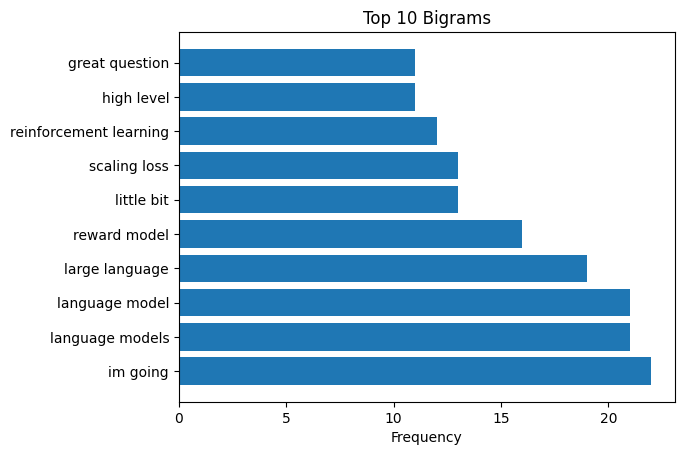

In [ ]:
# Visualizing the most common bigrams
most_common_bigrams = bigram_freq.most_common(10)
phrases, counts = zip(*most_common_bigrams)
plt.barh(phrases, counts)
plt.xlabel("Frequency")
plt.title("Top 10 Bigrams")
plt.show()

### To improve the quality of the bigram and trigram analysis, I incorporated lemmatization and filtering using spaCy

In [ ]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(" ".join(filtered_words))
important_words = [token.text for token in doc if token.pos_ not in ["AUX", "DET", "PRON", "CCONJ", "INTJ", "PART", "ADV"]]


In [ ]:
bigrams = list(ngrams(important_words, 2))
trigrams = list(ngrams(important_words, 3))

bigram_freq = Counter(bigrams)
trigram_freq = Counter(trigrams)

print("Most Common Bigrams:", bigram_freq.most_common(10))
print("Most Common Trigrams:", trigram_freq.most_common(10))

Most Common Bigrams: [(('language', 'models'), 21), (('language', 'model'), 21), (('large', 'language'), 19), (('reward', 'model'), 16), (('little', 'bit'), 13), (('scaling', 'loss'), 13), (('reinforcement', 'learning'), 12), (('high', 'level'), 11), (('great', 'question'), 11), (('s', 'lot'), 11)]
Most Common Trigrams: [(('large', 'language', 'models'), 10), (('large', 'language', 'model'), 9), (('supervised', 'fine', 'tuning'), 8), (('15', 'trillion', 'tokens'), 6), (('autoregressive', 'language', 'models'), 5), (('training', 'large', 'language'), 5), (('train', 'reward', 'model'), 5), (('large', 'corpus', 'text'), 3), (('give', 'concrete', 'example'), 3), (('s', 'great', 'question'), 3)]


In [ ]:
# Performing POS tagging and lemmatization, and filter out unimportant words
doc = nlp(" ".join(filtered_words))
important_words = [
    token.lemma_ for token in doc
    if token.pos_ not in ["AUX", "DET", "PRON", "CCONJ", "INTJ", "PART", "ADV"]
    and token.text.lower() not in ["little", "bit", "lot", "blah"]  # Custom filtering
]

# Generate bigrams and trigrams from the important words
bigrams = list(ngrams(important_words, 2))
trigrams = list(ngrams(important_words, 3))

# Count the frequency of bigrams and trigrams
bigram_freq = Counter(bigrams)
trigram_freq = Counter(trigrams)

# Print the most common bigrams and trigrams
print("Most Common Bigrams:", bigram_freq.most_common(10))
print("Most Common Trigrams:", trigram_freq.most_common(10))


Most Common Bigrams: [(('language', 'model'), 47), (('large', 'language'), 19), (('reward', 'model'), 16), (('model', 'generate'), 13), (('question', 'answer'), 13), (('great', 'question'), 12), (('train', 'model'), 11), (('high', 'level'), 11), (('one', 'thing'), 11), (('scale', 'loss'), 11)]
Most Common Trigrams: [(('large', 'language', 'model'), 19), (('autoregressive', 'language', 'model'), 7), (('train', 'large', 'language'), 6), (('15', 'trillion', 'token'), 6), (('supervise', 'fine', 'tuning'), 5), (('train', 'reward', 'model'), 5), (('large', 'corpus', 'text'), 4), (('train', 'large', 'model'), 4), (('use', 'reinforcement', 'learning'), 4), (('prefer', 'long', 'output'), 4)]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-49-199aa73d3bc8>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bigram_data, x="Frequency", y="Bigram", palette="viridis")


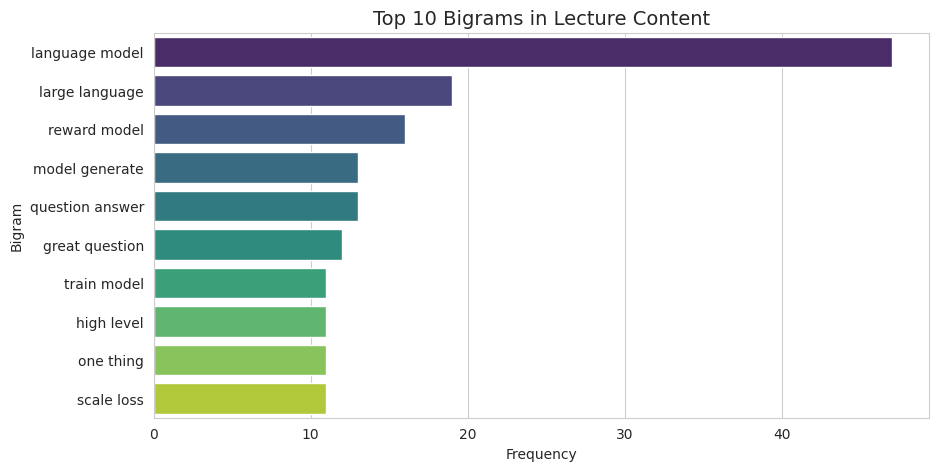

<ipython-input-49-199aa73d3bc8>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=trigram_data, x="Frequency", y="Trigram", palette="magma")


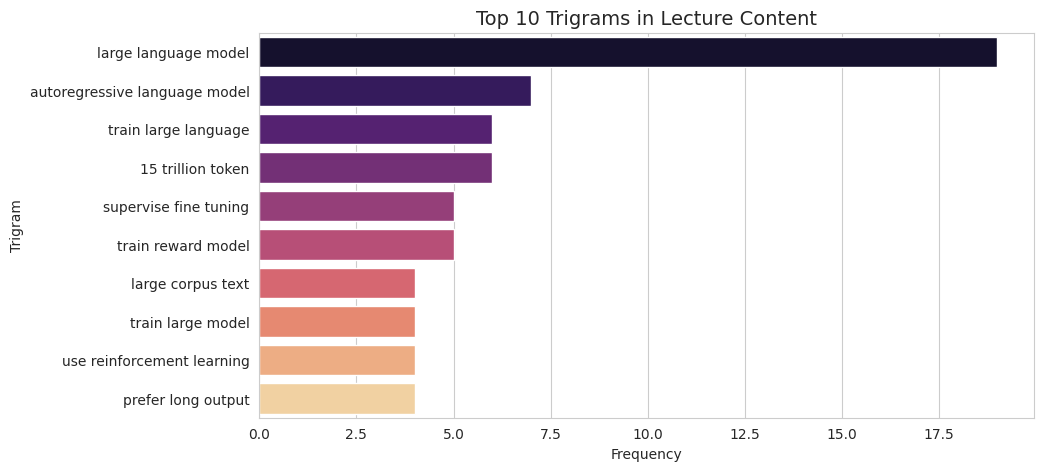

In [ ]:
import seaborn as sns
# Converting bigram and trigram frequencies to a DataFrame
bigram_data = pd.DataFrame(bigram_freq.most_common(10), columns=["Bigram", "Frequency"])
bigram_data["Bigram"] = bigram_data["Bigram"].apply(lambda x: " ".join(x))
trigram_data = pd.DataFrame(trigram_freq.most_common(10), columns=["Trigram", "Frequency"])
trigram_data["Trigram"] = trigram_data["Trigram"].apply(lambda x: " ".join(x))

sns.set_style("whitegrid")

# Plot Bigram Frequencies
plt.figure(figsize=(10, 5))
sns.barplot(data=bigram_data, x="Frequency", y="Bigram", palette="viridis")
plt.title("Top 10 Bigrams in Lecture Content", fontsize=14)
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.show()

# Plot Trigram Frequencies
plt.figure(figsize=(10, 5))
sns.barplot(data=trigram_data, x="Frequency", y="Trigram", palette="magma")
plt.title("Top 10 Trigrams in Lecture Content", fontsize=14)
plt.xlabel("Frequency")
plt.ylabel("Trigram")
plt.show()


**Interpretation**:The frequency analysis of bigrams and trigrams provides valuable insights into the key concepts and themes of the lecture. The most common phrases, such as "language model" and "large language model," highlight the main focus on topics related to language modeling and AI.

# SUMMARIZATION
The summarization efficiently condenses large volumes of the given transcription  into a digestible format, making it easier to understand.

In [ ]:
nltk.download('punkt')
nlp = spacy.load("en_core_web_md")

# Function to compute sentence embedding
def get_sentence_embedding(sentence):
    doc = nlp(sentence)
    return np.mean([token.vector for token in doc if token.has_vector], axis=0)

# Function to calculate cosine similarity
def cosine_similarity(vec1, vec2):
    return 1 - cosine(vec1, vec2)

def extract_key_sentences(text, num_sentences):
    sentences = sent_tokenize(text)
    similarity_matrix = nx.Graph()
    similarity_matrix.add_nodes_from(range(len(sentences)))

    # Compute the similarity between each pair of sentences using word embeddings
    for i in range(len(sentences)):
        for j in range(i + 1, len(sentences)):
            embedding_i = get_sentence_embedding(sentences[i])
            embedding_j = get_sentence_embedding(sentences[j])

            # Compute cosine similarity and add to the graph
            if embedding_i is not None and embedding_j is not None:
                similarity = cosine_similarity(embedding_i, embedding_j)
                similarity_matrix.add_edge(i, j, weight=similarity)
    scores = nx.pagerank(similarity_matrix)
    ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)

    # Extract the top-ranked sentences
    key_sentences = [sentence for score, sentence in ranked_sentences[:num_sentences]]
    return " ".join(key_sentences)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

def generate_abstractive_summary(text, input_length):
    max_length = min(240, input_length // 2)
    min_length = max(80, input_length // 4)

    # Tokenize and encode the text
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=1024, truncation=True)

    # Generate the summary
    summary_ids = model.generate(inputs, max_length=max_length, min_length=min_length, length_penalty=1.3, num_beams=6, early_stopping=True)

    # Decode the summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary


In [ ]:
desired_length = int(input("Enter the number of sentences you want in the summary: "))
key_sentences = extract_key_sentences(cleaned_text, num_sentences=desired_length)
print("\nKey Sentences: \n", key_sentences)
input_length = len(key_sentences.split())
abstractive_summary = generate_abstractive_summary(key_sentences, input_length)

print("\nAbstractive Summary: \n", abstractive_summary)


Enter the number of sentences you want in the summary: 7

Key Sentences: 
  so lets get started so ill be talking about building llms today so i think a lot of you have heard of llms before but just as a quick recap llms standing for large language models are basically all the chat bots that youve been hearing about recently so chad gpt from openai cloud from untropic gemini and lama and other type of models like this and today well be talking about how do they actually work so its going to be an overview because its only one lecture and its hard to compress everything but hopefully ill touch a little bit about all the components that are needed to train some of these llms also if you have questions please interrupt me and ask if you have a question most likely other people in the room or on zoom have the same question so please ask great so what matters when training llms so there are a few key components that matter one is the architecture so as you probably all know lms are neural n

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1282: UserWarning: Unfeasible length constraints: `min_length` (4544) is larger than the maximum possible length (240). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length.
  warnings.warn(



Abstractive Summary: 
 Llms standing for large language models are basically all the chat bots that youve been hearing about recently so chad gpt from openai cloud from untropic gemini and lama and other type of models like this and today well be talking about how do they actually work. There are a few key components that matter one is the architecture so as you probably all know lms are neural networks. Another component which is really important is the training loss and the training algorithm so how you actually train these models then its data so what do you trainThese models on the evaluation which is how do you know whether youre actually making progress towards the goal of llms and then the system component so that is likeHow do you actually make these models run on modern hardware which isreally important because these models are really large so now more than ever systems are actually really an important topic for llms so those five components are what matters when training llm

In [ ]:
abstractive_summary

'Llms standing for large language models are basically all the chat bots that youve been hearing about recently so chad gpt from openai cloud from untropic gemini and lama and other type of models like this and today well be talking about how do they actually work. There are a few key components that matter one is the architecture so as you probably all know lms are neural networks. Another component which is really important is the training loss and the training algorithm so how you actually train these models then its data so what do you trainThese models on the evaluation which is how do you know whether youre actually making progress towards the goal of llms and then the system component so that is likeHow do you actually make these models run on modern hardware which isreally important because these models are really large so now more than ever systems are actually really an important topic for llms so those five components are what matters when training llms. We talk about pretra

 I used a hybrid method for summarization to get the best of both worlds: pulling out key sentences directly from the text (extractive) while also rephrasing and making it sound more natural (abstractive). This way, the summary is short, clear, and still captures the main points in an easy-to-read way.

## Optimizing Keyword Identification on Summarized Data

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=10)
X = vectorizer.fit_transform([abstractive_summary])
keywords = vectorizer.get_feature_names_out()

print("Top Keywords:", keywords)


Top Keywords: ['actually' 'important' 'language' 'large' 'llms' 'models' 'paradigm'
 'pretraining' 'really' 'training']


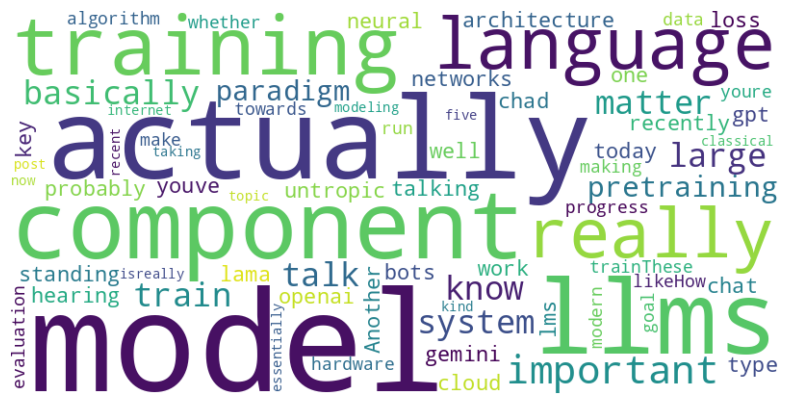

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(abstractive_summary)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


  

*   I chose **KeyBERT** over **TF-IDF** because TF-IDF focuses only on word frequency, often highlighting irrelevant or generic terms.
*   KeyBERT, powered by BERT, understands the semantic context of words, giving more accurate and meaningful keywords that truly represent the core themes, such as "LLMs," "models," and "neural networks."
This ensures a better and more relevant keyword extraction.



In [ ]:
kw_model = KeyBERT()
keywords = kw_model.extract_keywords(abstractive_summary, top_n=10)

print("Top Keywords:", [word for word, score in keywords])

Top Keywords: ['llms', 'lms', 'models', 'modeling', 'pretraining', 'language', 'architecture', 'model', 'chat', 'networks']


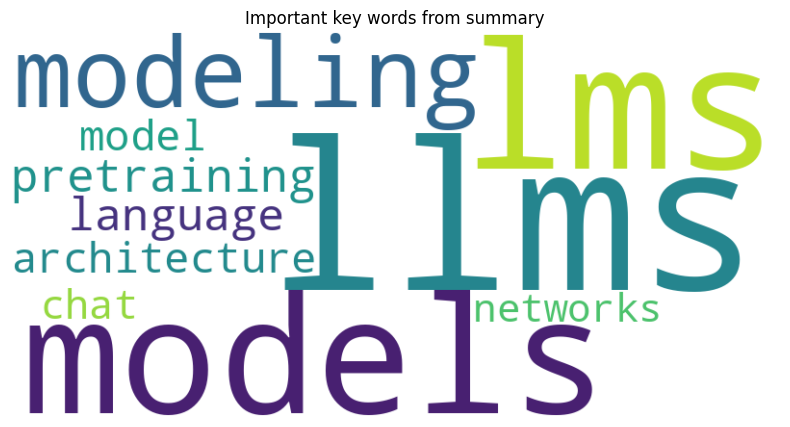

In [ ]:
keyword_dict = {word: score for word, score in keywords}

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    prefer_horizontal=1.0
).generate_from_frequencies(keyword_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Important key words from summary')
plt.show()

These keywords effectively capture the essential concepts ensuring a precise understanding of the main topics discussed.

# **Evaluation**

In [ ]:
!pip install Rouge

In [ ]:
from rouge import Rouge
rouge = Rouge()
scores = rouge.get_scores(abstractive_summary, transcription)[0]
rouge_scores = {
    "ROUGE-1": {'r': scores['rouge-1']['r'], 'p': scores['rouge-1']['p'], 'f': scores['rouge-1']['f']},
    "ROUGE-2": {'r': scores['rouge-2']['r'], 'p': scores['rouge-2']['p'], 'f': scores['rouge-2']['f']},
    "ROUGE-L": {'r': scores['rouge-l']['r'], 'p': scores['rouge-l']['p'], 'f': scores['rouge-l']['f']}
}


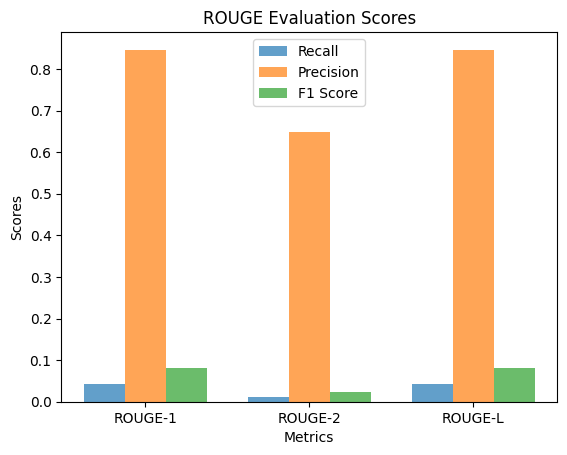

In [ ]:
metrics = list(rouge_scores.keys())
recall_scores = [rouge_scores[m]['r'] for m in metrics]
precision_scores = [rouge_scores[m]['p'] for m in metrics]
f1_scores = [rouge_scores[m]['f'] for m in metrics]

fig, ax = plt.subplots()
bar_width = 0.25
index = range(len(metrics))

ax.bar(index, recall_scores, bar_width, label='Recall', alpha=0.7)
ax.bar([i + bar_width for i in index], precision_scores, bar_width, label='Precision', alpha=0.7)
ax.bar([i + 2 * bar_width for i in index], f1_scores, bar_width, label='F1 Score', alpha=0.7)

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('ROUGE Evaluation Scores')
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(metrics)
ax.legend()

plt.show()


## Analysis of Results
The bar chart shows high Precision scores across all metrics, meaning the summary includes **highly relevant content**. However, Recall scores are lower, indicating that more content from the original text could be included for better coverage. The moderate F1 scores suggest the need for further fine-tuning to improve recall while keeping precision high.